# Forbes Surfaces: Aspheres and Freeforms

In modern optical design, **aspheric and freeform surfaces** are crucial for correcting aberrations, reducing system size, and improving performance. However, describing these complex shapes can be challenging. Traditional methods, like power-series polynomials, often lead to optimization difficulties and manufacturing sensitivities due to a lack of orthogonality.

**Forbes surfaces**, developed by Dr. G.W. Forbes, offer a more robust and intuitive solution by using a basis of orthogonal polynomials. This tutorial will first present the general mathematical theory for a freeform surface and then demonstrate how the simpler, rotationally symmetric **Q (slope-orthogonal)** surface is a special case of this powerful framework.

> **Note on terminology:** The rotationally symmetric Q polynomials are historically referred to as "Q^bfs" in the literature (Forbes 2007). The "bfs" originally stood for "best-fit sphere," but Forbes's 2011 generalization extends this formalism to any conic reference surface. In Optiland, we use the class name `ForbesQNormalSlopeGeometry` to emphasize that these polynomials are orthogonal with respect to the *normal slope* of the surface departure, rather than implying a spherical reference.

References: 

- [1] G. W. Forbes, "Manufacturability estimates for optical aspheres," Opt. Express 19(10), 9923–9941 (2011)
- [2] G. W. Forbes, "Characterizing the shape of freeform optics," Opt. Express 20, 2483-2499 (2012)

Note that the implementation of the Forbes surface in Optiland was adapted from the open-source package [prysm](https://github.com/brandondube/prysm/tree/master) to support Optiland's backend and other functionalities.

### Part 1: The General Theory of Forbes Freeform Surfaces (Q-2D)

The most general form of a Forbes surface can describe a freeform optic that lacks any rotational symmetry. The core innovation is the construction of a polynomial basis that is **orthogonal** with respect to the **gradient of the surface departure**, a physically meaningful metric for manufacturability and testing.

#### The Fundamental Freeform Sag Equation

From [2], **Eq. (2.2)**, the sag $z$ of a freeform optic is defined as a best-fit sphere plus a departure term, $\mathfrak{\delta}(u, \theta)$, projected along the normal of that sphere:

$$z(\rho, \theta) = \frac{c \rho^2}{1 + \sqrt{1 - c^2 \rho^2}} + \frac{1}{\sqrt{1 - c^2 \rho^2}} \mathfrak{\delta}(u, \theta)$$

The departure term $\mathfrak{\delta}(u, \theta)$, from **Eq. (3.1)** in [2], contains the full description of the surface's deviation from a sphere:

$$\mathfrak{\delta}(u, \theta) = \underbrace{u^2(1-u^2)\sum_{n=0}^{N} a_n^0 Q_n^0(u^2)}_{\text{Rotationally Symmetric Part}} + \underbrace{\sum_{m=1}^{M} u^m \sum_{n=0}^{N} [a_n^m \cos(m\theta) + b_n^m \sin(m\theta)] Q_n^m(u^2)}_{\text{Non-Symmetric (Freeform) Part}}$$

Here, the coefficients $a_n^m$ and $b_n^m$ control the amplitude of radial polynomials $Q_n^m(u^2)$ and azimuthal sinusoids, allowing for a complete and orthogonal description of the freeform shape.

#### Connection to `optiland` Code for Q-2D

The `optiland` API for `ForbesQ2dGeometry` uses a single, expressive dictionary called `freeform_coeffs` to define the surface. This approach avoids the need for parallel lists and makes the code more readable and intuitive. The keys of the dictionary follow the Zemax convention for intuitive use.

The following table breaks down the connection between the mathematical terms and the corresponding dictionary keys in the API:

| Mathematical Term | Description | `optiland` Dictionary Key |
|:------------------|:-----------------------------------------------------|:--------------------------|
| $a_n^m$           | **Cosine Term**: A freeform component with azimuthal order $m$ and radial order $n$. | `('a', m, n)`                  |
| $b_n^m$           | **Sine Term**: A freeform component with azimuthal order $m$ and radial order $n$.   | `('b', m, n)`           |
| $a_n^0$           | **Symmetric Term**: A rotationally symmetric component ($m=0$). | `('a', 0, n)`                  |

> **Note:** The index order `(m, n)` in the key matches the Zemax UI convention.

#### Example Implementation

To create a freeform surface with a symmetric term $a_4^0$, a cosine term $a_2^2$, and a sine term $b_3^1$, you would define the `freeform_coeffs` dictionary as follows:

```python
freeform_coeffs = {
    ('a', 0, 4): -0.01,    # Represents a_4^0 
    ('a', 2, 2): 0.05,     # Represents a_2^2 
    ('b', 1, 3): 0.02,     # Represents b_3^1 
}
```

which translates to an optical surface in Optiland as shown below:

(<Figure size 1000x400 with 1 Axes>, <Axes: xlabel='Z [mm]', ylabel='Y [mm]'>)

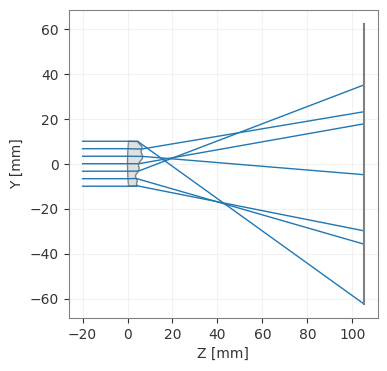

In [17]:
import optiland.backend as be
from optiland.optic import Optic

# 1. Initialize the optical system
optic = Optic(name="Forbes Q2D Singlet Example")
optic.set_aperture(aperture_type="EPD", value=20.0)
optic.add_wavelength(value=0.55, is_primary=True, unit="um")
optic.set_field_type(field_type="angle")
optic.add_field(y=0.0)

# 2. Define the Forbes surface parameters
norm_radius = 10.0
freeform_coeffs = {
            ('a', 0, 0): 1.0,   # Symmetric term a_0^0
            ('a', 1, 1): 2.0,   # Cosine term a_1^1
            ('b', 1, 1): 3.0,   # Sine term b_1^1
            ('a', 0, 4): 4.0,   # Symmetric term a_4^0
}
# 3. Add the surfaces
optic.add_surface(index=0, thickness=be.inf)  # Object plane
optic.add_surface(index=1, radius=100, thickness=5.0, material="N-BK7", is_stop=True)
optic.add_surface(
    index=2,
    surface_type="forbes_q2d",
    radius=-100,
    conic=-0.8,
    thickness=100.0,
    material="air",
    freeform_coeffs=freeform_coeffs,
    norm_radius=norm_radius,
    aperture=20.0
)
optic.add_surface(index=3)  # Image plane

optic.draw(num_rays=7)

and we can visualize this surface's sag using Optilands built-in sag analyzer, via ``optic.plot_surface_sag()``

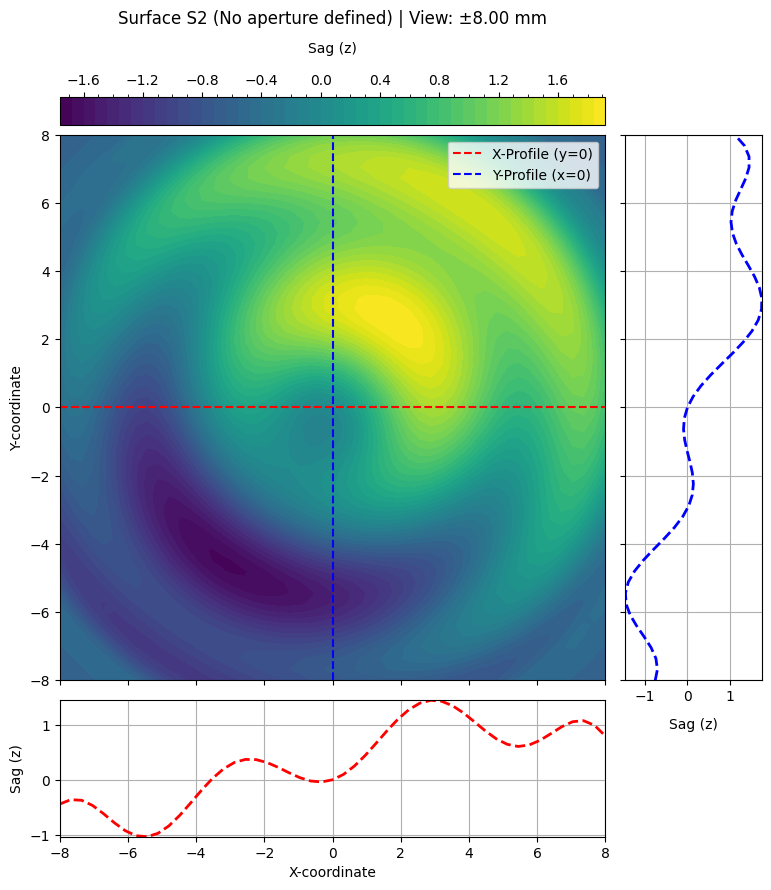

In [14]:
optic.plot_surface_sag(surface_index=2, max_extent=8.0, num_points_grid=51)

### Part 2: The Rotationally Symmetric Q (Slope-Orthogonal) Surface

We can derive the simpler, rotationally symmetric Q surface equation directly from the general freeform theory.

A surface is rotationally symmetric if, and only if, its sag $z$ does not depend on the azimuthal angle $\theta$. For this to be true, all terms in the departure equation $\mathfrak{\delta}(u, \theta)$ that contain a $\theta$ dependence must vanish. This occurs when all coefficients for the Non-Symmetric Part are zero:

$$ a_n^m = 0 \quad \text{and} \quad b_n^m = 0 \quad \forall \ m \ge 1 $$

Applying this condition simplifies the general departure term to only its rotationally symmetric component:

$$ \mathfrak{\delta}(u, \theta) \rightarrow \mathfrak{\delta}(u) = u^2(1-u^2)\sum_{n=0}^{N} a_n^0 Q_n^0(u^2) $$

Substituting this back into the general sag equation gives us the formula for a rotationally symmetric Q surface based on a sphere. Generalizing this to a conic base, as shown in [1], **Eq. (2.4)**, gives the final sag equation:

$$ z_{\text{total}} = \underbrace{ \frac{c\rho^2}{1 + \sqrt{1 - (1+k)c^2\rho^2}} }_{z_{\text{base}}} + \underbrace{ \frac{1}{\sigma(\rho)} \left[ u^2(1-u^2) \sum_{m=0}^{M} a_m Q_m(u^2) \right] }_{\text{Departure Term}} $$

This is the fundamental equation for the slope-orthogonal Q surface, now understood as a special case of the broader freeform theory.

#### Connection to `optiland` Code

The parameters in the `optiland.geometries.ForbesQNormalSlopeGeometry` class map directly to these variables:

| Mathematical Symbol | `optiland` Parameter | Description |
|:--------------------|:---------------------|:---------------------------------------------------------------|
| $c$ (or $R$)        | `radius`             | The vertex radius of curvature of the base conic ($R=1/c$).      |
| $k$                 | `conic`              | The conic constant of the base conic. |
| $\rho_{\text{max}}$ | `forbes_norm_radius` | The normalization radius used to define $u = \rho / \rho_{\text{max}}$. |
| $a_n$               | `radial_terms`       | A dictionary mapping radial order `n` to coefficient `a_n`. |

#### Implementation in `Optiland` 

The `ForbesQNormalSlopeGeometry` class makes it straightforward. You can also use `surface_type="forbes_qbfs"` when adding surfaces for convenience (the legacy name is preserved for backward compatibility).

##### Key Parameters

When you create a `ForbesQNormalSlopeGeometry` surface, you'll use the following parameters, which map directly from the mathematics:

* `radius`: The vertex radius of curvature, $R = 1/c$.
* `conic`: The conic constant, $k$.
* `forbes_norm_radius`: The normalization radius, $h$. This is typically set to the semi-aperture (or clear aperture) of the surface.
* `radial_terms`: A dictionary where keys are the integer radial order `n` and values are the float coefficient values `a_n`. For example, `{0: 0.5, 1: 0.1}`.

(<Figure size 1000x400 with 1 Axes>, <Axes: xlabel='Z [mm]', ylabel='Y [mm]'>)

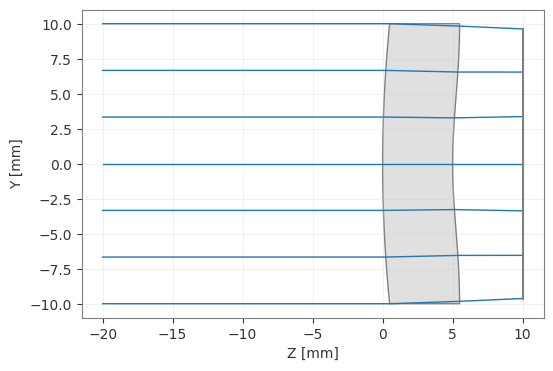

In [20]:
import optiland.backend as be
from optiland.optic import Optic

# 1. Initialize the optical system
optic = Optic(name="Forbes Q (Slope-Orthogonal) Singlet Example")
optic.set_aperture(aperture_type="EPD", value=20.0)
optic.add_wavelength(value=0.55, is_primary=True, unit="um")
optic.set_field_type(field_type="angle")
optic.add_field(y=0.0)

# 2. Define the Forbes surface parameters
norm_radius = 10.0
radial_terms = {
    0: 0.5,  # a0 coefficient
    1: 0.1,  # a1 coefficient
}

# 3. Add the surfaces
# Note: surface_type="forbes_qbfs" is the legacy name, still supported for
# backward compatibility. The canonical class is ForbesQNormalSlopeGeometry.
optic.add_surface(index=0, thickness=be.inf)  # Object plane
optic.add_surface(index=1, radius=100, thickness=5.0, material="N-BK7", is_stop=True)
optic.add_surface(
    index=2,
    surface_type="forbes_qbfs",  # Legacy name, creates ForbesQNormalSlopeGeometry
    radius=100,
    conic=-0.8,
    thickness=5.0,
    material="air",
    radial_terms=radial_terms,
    norm_radius=norm_radius,
)
optic.add_surface(index=3)  # Image plane

optic.draw(num_rays=7)

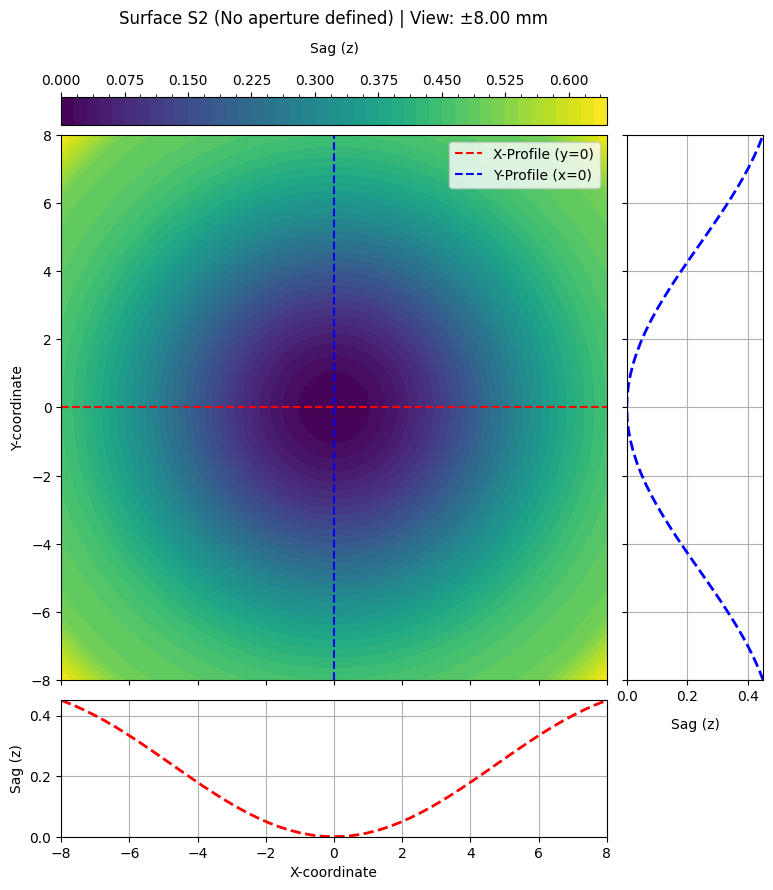

In [21]:
optic.plot_surface_sag(surface_index=2, max_extent=8.0, num_points_grid=51)